<a href="https://colab.research.google.com/github/daddysin777/PyTorchDeepLearning/blob/main/CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

# Torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

# Visualisation
import matplotlib.pyplot as plt

# Data

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11725442.00it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207887.42it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3877336.83it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5566454.50it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
image, label = train_data[0]
print(f"Image shape: {image.shape} | Label: {label}")
print(f"M(training): {len(train_data.data)} | M(test): {len(test_data.data)}")

Image shape: torch.Size([1, 28, 28]) | Label: 9
M(training): 60000 | M(test): 10000


In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

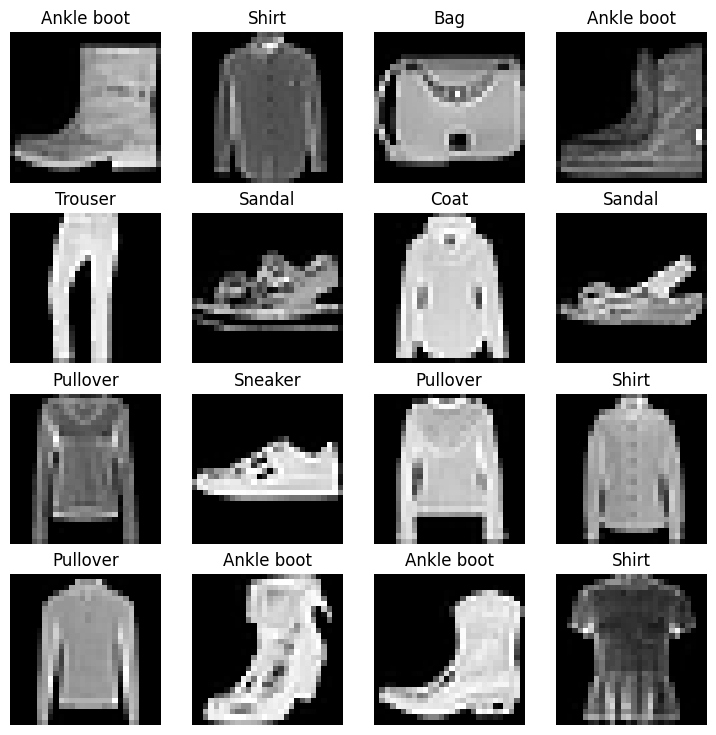

In [5]:
# Plot images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a8c08271750>, <torch.utils.data.dataloader.DataLoader object at 0x7a8c08273580>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


# Model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
class FashionMNISTModelV0(nn.Module):
  """
  Copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

In [9]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

FashionMNISTModelV0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [11]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Training

In [12]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Average train loss and accuracy
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
           data_loader: torch.utils.data.DataLoader,
           loss_fn: torch.nn.Module,
           accuracy_fn,
           device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [13]:
def eval_model(model: torch.nn.Module,
           data_loader: torch.utils.data.DataLoader,
           loss_fn: torch.nn.Module,
           accuracy_fn,
           device: torch.device = device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [14]:
torch.manual_seed(42)

epochs = 3
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------------------")
  train_step(model=model_0, data_loader=train_dataloader,
             loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
  test_step(model=model_0, data_loader=test_dataloader,
            loss_fn=loss_fn, accuracy_fn=accuracy_fn)

Epoch: 0
---------------------
Train loss: 0.59360 | Train accuracy: 78.42%
Test loss: 0.38897 | Test accuracy: 86.06%

Epoch: 1
---------------------
Train loss: 0.35902 | Train accuracy: 87.07%
Test loss: 0.36456 | Test accuracy: 86.56%

Epoch: 2
---------------------
Train loss: 0.32324 | Train accuracy: 88.33%
Test loss: 0.32207 | Test accuracy: 88.35%



In [15]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.3220687210559845,
 'model_acc': 88.34864217252397}

# Results

In [16]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [17]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [18]:
pred_probs = make_predictions(model=model_0, data=test_samples)
pred_probs[:2]

tensor([[1.8759e-07, 2.5889e-08, 7.8248e-08, 4.7526e-08, 5.7808e-09, 9.9981e-01,
         6.4716e-08, 7.9274e-06, 3.2396e-05, 1.4595e-04],
        [4.8968e-02, 6.7414e-01, 3.3284e-03, 4.0762e-02, 8.1787e-02, 2.0064e-04,
         1.5042e-01, 7.6433e-05, 7.6117e-05, 2.3684e-04]])

In [19]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

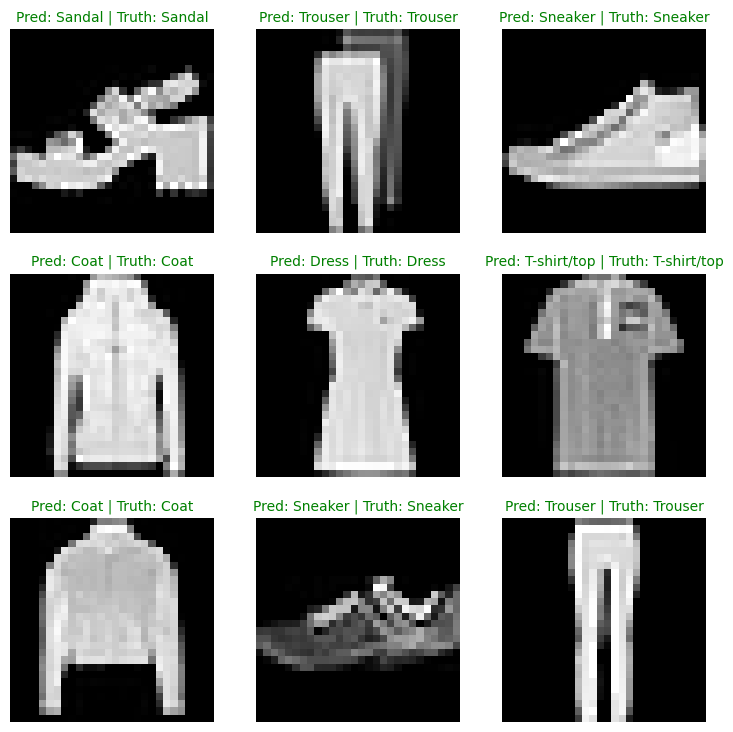

In [20]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):

  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);

In [25]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    y_logit = model_0(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [27]:
# See if torchmetrics exists, if not, install it
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.4 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [28]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


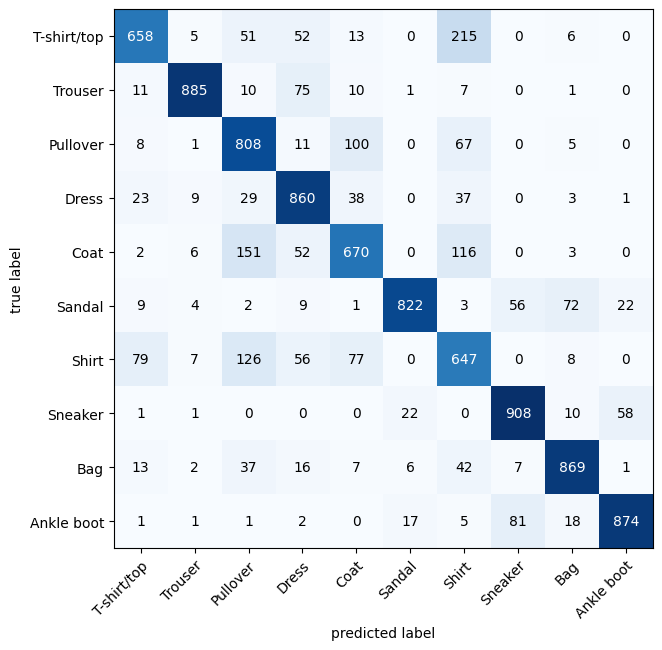

In [29]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [32]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [34]:
loaded_model_0 = FashionMNISTModelV0(
    input_shape=1,
    hidden_units=10,
    output_shape=10
)

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0 = loaded_model_0.to(device)

In [36]:
torch.manual_seed(42)

loaded_model_0_results = eval_model(
    model=loaded_model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

In [37]:
loaded_model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.3220687210559845,
 'model_acc': 88.34864217252397}